In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes
    %pip install einops

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    from google.colab import drive
    drive.mount('/content/drive/')

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1

In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.dataset_handling import TextDataset, TextClassificationDataset
from src.utils import get_hidden_activations, activation_label_generator
from src.sparse_autoencoders import SAE_topk
import tqdm.auto as tqdm

import json
import pandas as pd
import os
from matplotlib import pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# For the base model
url = "EleutherAI/pythia-1.4b"
hookpoints = ["gpt_neox.layers.16.mlp.act"]
out_folder = f"models/sparse_autoencoders/{url.split('/')[-1]}"
log_folder = f"training_logs/sparse_autoencoders/{url.split('/')[-1]}"

model = AutoModelForCausalLM.from_pretrained(url).to(device)
tokenizer = AutoTokenizer.from_pretrained(url)
batch_size = 32
learning_rate = 1e-3

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [4]:
# SAE data

input_size = model.config.intermediate_size

expansion_factor = 8

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 32,
    "pre_encoder_bias": True,
    "same_W": False
}


sae = SAE_topk(meta_data=meta_data).to(device)

In [5]:
class SaeTrainer():
    def __init__(self, meta_data, learning_rate, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []


    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        hiddens = self.model.activations
        active_neurons = len(torch.unique(hiddens.indices))

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [6]:
sae_trainers = [
    SaeTrainer(meta_data, learning_rate, hookpoint, device)
    for hookpoint in hookpoints
]

In [7]:
for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for sae_trainer in sae_trainers:
        activation = activations[sae_trainer.hookpoint]
        label = activation.detach()
        loss, active_neurons = sae_trainer.train_step(activation, label)
        print(f'{loss}\t{active_neurons}', end='')
    print('')

  0%|          | 0/2070 [00:00<?, ?it/s]

0.05928069353103638	4717
0.05921005457639694	1155
0.05650658160448074	822
0.05362369865179062	1505
0.04896865785121918	1642
0.04663992300629616	1053
0.04459834471344948	1270
0.044552695006132126	1266
0.041022542864084244	1318
0.04433559253811836	897
0.04542790725827217	1406
0.03911559283733368	1210
0.0416715107858181	1214
0.03823116794228554	2105
0.03756391629576683	1373
0.034707557410001755	1696
0.03891017660498619	3197
0.03947187215089798	1651
0.037326306104660034	3252
0.037143025547266006	2070
0.03476626053452492	2623
0.03467362001538277	2377
0.03704458847641945	2296
0.032188914716243744	2756
0.03380555659532547	2401
0.03417515382170677	2519
0.030109429731965065	2445
0.030593058094382286	3358
0.03072643280029297	2992
0.030758118256926537	2917
0.030518775805830956	2377
0.029418881982564926	2660
0.02950969524681568	1976
0.02861788682639599	2295
0.029016954824328423	2365
0.027345849201083183	2059
0.027955789119005203	2077
0.028632963076233864	2302
0.02649357169866562	1994
0.02887415513

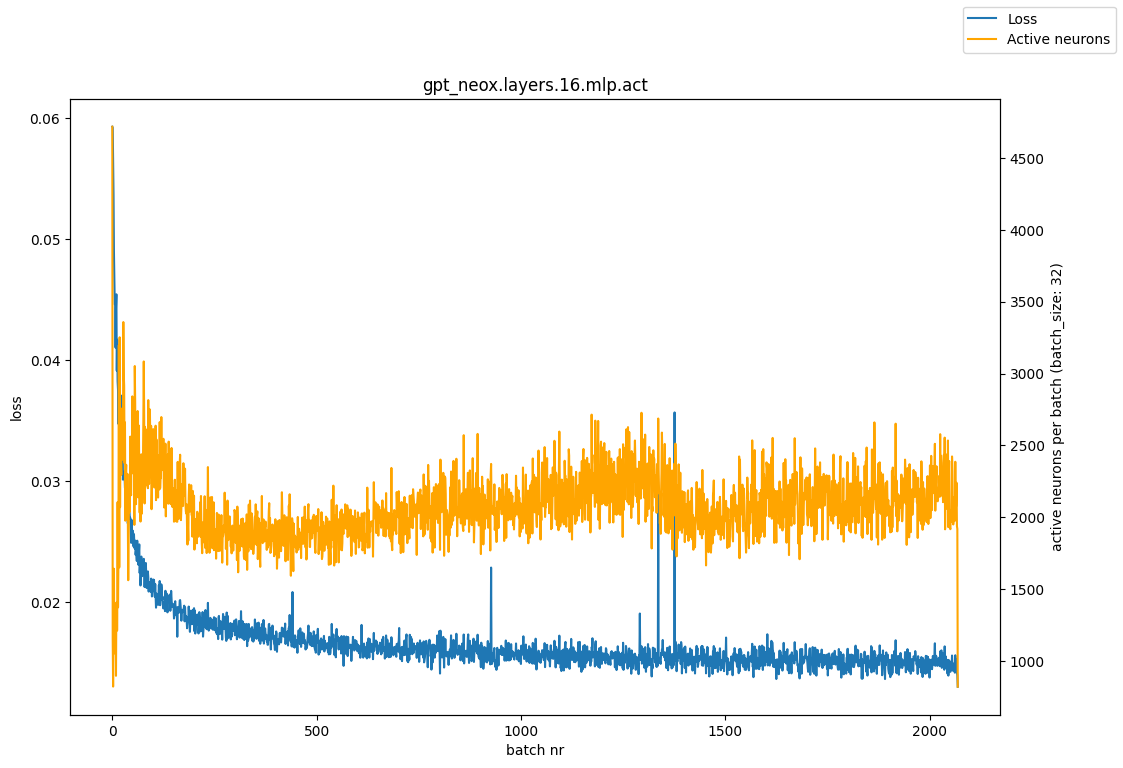

In [9]:
for sae_trainer in sae_trainers:
    hookpoint = sae_trainer.hookpoint
    k = sae_trainer.model.meta_data['k']

    model_out_path = f'../drive/MyDrive/models/{hookpoint}.pt'
    meta_data_out_path = f'{out_folder}/topk{k}/{hookpoint}.json'
    log_path = f'{log_folder}/topk{k}/{hookpoint}.csv'
    log_fig_path = f'{log_folder}/topk{k}/{hookpoint}.png'


    if not os.path.isdir(f'{out_folder}'):
        os.mkdir(f'{out_folder}')
    if not os.path.isdir(f'{log_folder}'):
        os.mkdir(f'{log_folder}')

    if not os.path.isdir(f'{out_folder}/topk{k}'):
        os.mkdir(f'{out_folder}/topk{k}')
    if not os.path.isdir(f'{log_folder}/topk{k}'):
        os.mkdir(f'{log_folder}/topk{k}')

    torch.save(sae_trainer.model.state_dict(), model_out_path)

    new_meta = {key: value for key, value in meta_data.items()}
    new_meta['batch_size'] = batch_size
    new_meta['num_batches_trained_on'] = sae_trainer.batches
    new_meta['hookpoint'] = sae_trainer.hookpoint
    new_meta['learning_rate'] = learning_rate

    with open(meta_data_out_path, 'w') as file:
        json.dump(new_meta, file, indent=4)

    loss_log, active_neurons_log = zip(*sae_trainer.losses)
    df = pd.DataFrame({
        'loss': loss_log,
        'active_neurons': active_neurons_log
    })
    df.to_csv(log_path)

    sae_trainer.plot_loss(out_file=log_fig_path)

In [10]:
!git add {out_folder}
!git add {log_folder}
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   models/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.json
	new file:   training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.csv
	new file:   training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.png



In [12]:
!git config --global user.email
!git config --global user.name "Markus Sibbesen"

In [13]:
!git commit -m "meta data and logs for big model trained"

[main 19cccbe] meta data and logs for big model trained
 3 files changed, 2082 insertions(+)
 create mode 100644 models/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.json
 create mode 100644 training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.csv
 create mode 100644 training_logs/sparse_autoencoders/pythia-1.4b/topk32/gpt_neox.layers.16.mlp.act.png


In [14]:
!git push

Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 12 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (13/13), 380.03 KiB | 13.10 MiB/s, done.
Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/MarkusSibbesen/mechinterp_research_project.git
   498dc99..19cccbe  main -> main
